En este notebook, vamos a trabajar con una tecnica de boosting que también es un método de aprendizaje ensemble, pero en este caso entrena modelos "debiles" secuencialmente, corrigiendo los errores del modelo anterior.

Más en concreto con XGBoost, importemos lo que creemos necesario y procedamos a traer nuevamente nuestro pipeline de preprocesamiento, en esta ocasión nuevamente comentaremos el esacalado de los datos, ya que, tampoco hacen que el modelo mejore, de nuevo, puede ser contraproducente.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
import os
import xgboost as xgb
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.metrics import confusion_matrix, classification_report, recall_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV, StratifiedKFold

In [3]:
os.chdir('/content/drive/MyDrive/data_fraud')

In [4]:
#supongamos que aquí llamamos a nuestros datos de entrenamiento
train_data = pd.read_csv('train.csv')

# Definimos la función para eliminar columnas
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Columnas con alta cardinalidad
        high_cardinality_cols = ['P_emaildomain', 'R_emaildomain', 'id_30', 'id_31', 'id_33', 'DeviceInfo']

        # Columnas con muchos valores nulos (umbral 50%)
        null_cols = ['dist1', 'dist2', 'D2', 'D5', 'D6', 'D7', 'D8', 'D9', 'D11', 'D12', 'D13', 'D14', 'M1', 'M2', 'M3', 'M5', 'M7',
                    'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V138', 'V139', 'V140', 'V141',
                    'V142', 'V143', 'V144', 'V145', 'V146', 'V147', 'V148', 'V149', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155',
                    'V156', 'V157', 'V158', 'V159', 'V160', 'V161', 'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V168', 'V169',
                    'V170', 'V171', 'V172', 'V173', 'V174', 'V175', 'V176', 'V177', 'V178', 'V179', 'V180', 'V181', 'V182', 'V183',
                    'V184', 'V185', 'V186', 'V187', 'V188', 'V189', 'V190', 'V191', 'V192', 'V193', 'V194', 'V195', 'V196', 'V197',
                    'V198', 'V199', 'V200', 'V201', 'V202', 'V203', 'V204', 'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V211',
                    'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 'V218', 'V219', 'V220', 'V221', 'V222', 'V223', 'V224', 'V225',
                    'V226', 'V227', 'V228', 'V229', 'V230', 'V231', 'V232', 'V233', 'V234', 'V235', 'V236', 'V237', 'V238', 'V239',
                    'V240', 'V241', 'V242', 'V243', 'V244', 'V245', 'V246', 'V247', 'V248', 'V249', 'V250', 'V251', 'V252', 'V253',
                    'V254', 'V255', 'V256', 'V257', 'V258', 'V259', 'V260', 'V261', 'V262', 'V263', 'V264', 'V265', 'V266', 'V267',
                    'V268', 'V269', 'V270', 'V271', 'V272', 'V273', 'V274', 'V275', 'V276', 'V277', 'V278', 'V322', 'V323', 'V324',
                    'V325', 'V326', 'V327', 'V328', 'V329', 'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338',
                    'V339', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12',
                    'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25',
                    'id_26', 'id_27', 'id_28', 'id_29', 'id_32', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType']

        # Columnas constantes
        constant_cols = ['V305']

        # Columnas altamente correlacionadas
        corr_cols = {'V62', 'V84', 'C2', 'C11', 'V302', 'C14', 'V45', 'V301', 'V65', 'V280', 'V279', 'V299', 'V308', 'V76', 'C12',
                    'V309', 'V42', 'C6', 'C9', 'V64', 'V73', 'V33', 'V134', 'V137', 'V93', 'V94', 'V28', 'V90', 'V38', 'V125', 'V136',
                    'V119', 'V307', 'V30', 'V79', 'V60', 'V24', 'V113', 'V128', 'V48', 'V34', 'V22', 'V70', 'V91', 'V133', 'V291',
                    'V40', 'V97', 'V285', 'V292', 'C4', 'V36', 'V49', 'V105', 'V87', 'V294', 'V32', 'V284', 'V109', 'V306', 'V289',
                    'V297', 'V106', 'V124', 'V88', 'V102', 'V89', 'V31', 'V316', 'V16', 'V63', 'V13', 'V295', 'V101', 'V83', 'V311',
                    'C10', 'V131', 'V72', 'V43', 'V96', 'C13', 'V20', 'V69', 'V112', 'V21', 'V100', 'V318', 'V54', 'V111', 'V123',
                    'V317', 'V303', 'V57', 'V298', 'V18', 'V287', 'V315', 'C7', 'V59', 'V15', 'V52', 'V58', 'V118', 'V320', 'V110',
                    'V78', 'V85', 'V321', 'V312', 'V92', 'V50', 'TransactionDT', 'V127', 'V122', 'V304', 'V81', 'V71', 'V80', 'V74',
                    'V26', 'V116', 'V293', 'V103', 'V310', 'C8', 'V132', 'V51', 'V114', 'V296', 'V68', 'V126'}

        # Columnas no predictivas
        non_predictive_cols = ['TransactionID']

        # Combinamos todas las columnas a eliminar
        all_cols_to_drop = high_cardinality_cols + null_cols + constant_cols + list(corr_cols) + non_predictive_cols

        # Eliminamos las columnas
        X = X.drop(columns=all_cols_to_drop)

        return X

# Funciones de transformación
def log_transform(x):
    return np.log1p(x)

def inverse_log_transform(x):
    x_reflected = x.max() - x  # Reflejamos valores
    return np.log1p(x_reflected)

def sqrt_transform(x):
    return np.sqrt(abs(x))

# Columnas categóricas y numéricas
categorical_features = ['ProductCD', 'card4', 'card6', 'M4', 'M6']
numeric_mean_log_cols = ['V66']
numeric_median_log_cols = ['TransactionAmt', 'card3', 'C1', 'C3', 'C5', 'D3', 'V17',
                           'V23', 'V27', 'V37', 'V39', 'V44', 'V46', 'V47', 'V55', 'V56',
                           'V67', 'V77', 'V86', 'V95', 'V98', 'V99', 'V104', 'V108', 'V115',
                           'V117', 'V120', 'V121', 'V129', 'V130', 'V135', 'V281', 'V282', 'V283',
                           'V286', 'V288', 'V290', 'V300', 'V313', 'V314', 'V319']
numeric_median_sqrt_cols = ['card5', 'D1', 'D4', 'D10', 'D15']
numeric_median_inv_cols = ['addr2', 'V14', 'V25', 'V41', 'V107']
numeric_mean_cols = ['card1', 'card2', 'addr1', 'V12', 'V35', 'V53', 'V61', 'V75']
numeric_median_cols = ['V19', 'V29', 'V82']

# Creamos los transformadores
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numeric_mean_log_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('log', FunctionTransformer(log_transform)),
    #('scaler', StandardScaler())
])

numeric_median_log_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('log', FunctionTransformer(log_transform)),
    #('scaler', StandardScaler())
])

numeric_median_sqrt_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('sqrt', FunctionTransformer(sqrt_transform)),
    #('scaler', StandardScaler())
])

numeric_median_inv_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('inv', FunctionTransformer(inverse_log_transform)),
    #('scaler', StandardScaler())
])

numeric_mean_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    #('scaler', StandardScaler())
])

numeric_median_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    #('scaler', StandardScaler())
])

# Unir los transformadores en un preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num_mean_log', numeric_mean_log_transformer, numeric_mean_log_cols),
        ('num_median_log', numeric_median_log_transformer, numeric_median_log_cols),
        ('num_median_sqrt', numeric_median_sqrt_transformer, numeric_median_sqrt_cols),
        ('num_median_inv', numeric_median_inv_transformer, numeric_median_inv_cols),
        ('num_mean', numeric_mean_transformer, numeric_mean_cols),
        ('num_median', numeric_median_transformer, numeric_median_cols),
        ('cat', categorical_transformer, categorical_features)
    ])

# Crear el pipeline completo
pipeline = Pipeline(steps=[('drop_columns', DropColumns()),
                           ('preprocessor', preprocessor)])

# Separar el target y las características
X_train = train_data.drop(columns=['isFraud'])
y_train = train_data['isFraud']

# Ajustar el pipeline y transformar los datos
X_train_prepared = pipeline.fit_transform(X_train)

# Ahora X_train_prepared esta listo para ser usado en los algoritmos de entrenamiento

Hemos visto ya que los modelos trabajan mucho mejor cuando les damos clases balanceadas en el entrenamiento, por lo que nuevamente generaremos datos que complemente nuestra clase minoritaria, una vez más con la técnica SMOTE.

In [5]:
# generamos nuestros datos sintéticos

from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority', random_state=42)
X_train_prepared, y_train = smote.fit_resample(X_train_prepared, y_train)

In [6]:
# contamos los ejemplos de ambas clases psrs ver si los datos quedaron listos
unique_values, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique_values, counts)))

{np.int64(0): np.int64(119999), np.int64(1): np.int64(119999)}


Y listo, ahora si vamos por nuestro primer intento.

In [6]:
# Definimos nuestro modelo base
xgb_model_1 = xgb.XGBClassifier(random_state=42)

xgb_model_1.fit(X_train_prepared, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [10]:
# traemos nuestros datos de validación
val_data = pd.read_csv('val.csv')

X_val = val_data.drop(columns=['isFraud'])
y_val = val_data['isFraud']

# Preprocesamos los datos de validación
x_val_prepared = pipeline.transform(X_val)

In [8]:
y_val_pred = xgb_model_1.predict(x_val_prepared)

In [9]:
# Vamos a ver nuestras metricas
acc_val = accuracy_score(y_val, y_val_pred)
recall_val = recall_score(y_val, y_val_pred)
conf_matrix_val = confusion_matrix(y_val, y_val_pred)

print(f"Accuracy en validación: {acc_val}")
print(f"Recall en validación: {recall_val}")
print("Matriz de confusión:")
print(conf_matrix_val)

Accuracy en validación: 0.9376883511204768
Recall en validación: 0.5354464069683039
Matriz de confusión:
[[39170   830]
 [ 1920  2213]]


El modelo base predice bien las transacciones legítimas, sin embargo, queremos que detecte más fraudes, debemos hacer una búsqueda de nuestros mejores hiperparámetros.

In [18]:
# Definimos hiperparámetros para búsqueda
#param_dist = {
#    'n_estimators': [100, 200, 300, 400, 500, 1000, 1500, 2000],
#    'max_depth': [3, 5, 6, 7, 10, 15, 20],
#    'learning_rate': [0.001, 0.005,  0.01, 0.05, 0.1, 0.2],
#    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
#    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
#    'scale_pos_weight': [10, 20, 30]
#}

# Nuevo espacio de hiperparámetros
param_dist = {
    'n_estimators': [500, 700, 1000],
    'max_depth': [10, 15],                # Menor profundidad
    'learning_rate': [0.2, 0.1, 0.05],      # Tasa de aprendizaje mayor
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
    'scale_pos_weight': [1]               # Como nuestros datos están balanceados, 1 es lo ideal
}

# Creamos la instancia del modelo
modelo_xgb = xgb.XGBClassifier(tree_method='gpu_hist', random_state=42)

# Configuración de RandomizedSearchCV
random_search = RandomizedSearchCV(
    modelo_xgb,
    param_distributions=param_dist,
    n_iter=20,
    scoring='f1',  # Usamos F1 para balancear precision y recall
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Entrenamos el modelo
random_search.fit(X_train_prepared, y_train)

# Mejor modelo encontrado
best_model = random_search.best_estimator_

# Predicción en validación
y_val_predict = best_model.predict(x_val_prepared)

# Métricas
acc_val = accuracy_score(y_val, y_val_predict)
recall_val = recall_score(y_val, y_val_predict)
conf_matrix_val = confusion_matrix(y_val, y_val_predict)

print(f"Accuracy en validación: {acc_val}")
print(f"Recall en validación: {recall_val}")
print("Matriz de confusión:")
print(conf_matrix_val)
print("Mejores hiperparámetros:", random_search.best_params_)



Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:19:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Accuracy en validación: 0.9523712414746335
Recall en validación: 0.6474715702879265
Matriz de confusión:
[[39355   645]
 [ 1457  2676]]
Mejores hiperparámetros: {'subsample': 0.8, 'scale_pos_weight': 1, 'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.1, 'colsample_bytree': 0.9}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:20:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Creamos un modelo con los mejores hiperparámetros que arrojo nuestra búsqueda.

In [7]:
mejor_modelo_xgb = xgb.XGBClassifier(subsample = 0.8, scale_pos_weight = 1, n_estimators = 500, max_depth = 15, learning_rate = 0.1, colsample_bytree = 0.9)

In [8]:
mejor_modelo_xgb.fit(X_train_prepared, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [11]:
# Obtenemos probabilidades en validación
y_val_probs = mejor_modelo_xgb.predict_proba(x_val_prepared)[:, 1]

# Ajustamos el umbral de clasificación
nuevo_umbral = 0.01
y_val_adjusted = (y_val_probs > nuevo_umbral).astype(int)

# Evaluamos el nuevo recall
recall_val_adj = recall_score(y_val, y_val_adjusted)
print(f"Nuevo Recall en validación: {recall_val_adj}")

acc_val_adj = accuracy_score(y_val, y_val_adjusted)
print(f"Nuevo Accuracy en validación: {acc_val_adj}")


Nuevo Recall en validación: 0.9061214614081781
Nuevo Accuracy en validación: 0.8153762490653252


De esta forma, nuestro modelo parece detectar mas del 90% de fraudes, sacrificando alrededor del 20% de la detección de operaciones auténticas. Vamos a juntar todo en nuestro pipeline final.

In [12]:
class ThresholdClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_classifier, threshold=0.5):
        self.base_classifier = base_classifier
        self.threshold = threshold

    def fit(self, X, y):
        self.base_classifier.fit(X, y)
        return self

    def predict(self, X):
        probs = self.base_classifier.predict_proba(X)[:, 1]
        return (probs >= self.threshold).astype(int)

    def predict_proba(self, X):
        return self.base_classifier.predict_proba(X)

In [13]:
# Creamos una instancia del clasificador con umbral personalizado, en este caso 0.01
threshold_classifier = ThresholdClassifier(mejor_modelo_xgb, threshold=0.01)

# Creamos el pipeline final con el clasificador de umbral
pipeline_final_xgb = Pipeline([
    ('preprocesamiento', pipeline),
    ('modelo', threshold_classifier)
])


In [14]:
# Vemos en un esquema como se ve nuestro pipeline

from sklearn import set_config
set_config(display='diagram')
pipeline_final_xgb

Pipeline(steps=[('preprocesamiento',
                 Pipeline(steps=[('drop_columns', DropColumns()),
                                 ('preprocessor',
                                  ColumnTransformer(transformers=[('num_mean_log',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('log',
                                                                                    FunctionTransformer(func=<function log_transform at 0x7c5726964fe0>))]),
                                                                   ['V66']),
                                                                  ('num_median_log',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='media...
                                                                   grow_policy=None,
                                                                   importance_type=None,
                                                                   interaction_constraints=None,
                                                                   learning_rate=0.1,
                                                                   max_bin=None,
                                                                   max_cat_threshold=None,
                                                                   max_cat_to_onehot=None,
                                                                   max_delta_step=None,
                                                                   max_depth=15,
                                                                   max_leaves=None,
                                                                   min_child_weight=None,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   multi_strategy=None,
                                                                   n_estimators=500,
                                                                   n_jobs=None,
                                                                   num_parallel_tree=None,
                                                                   random_state=None, ...),
                                     threshold=0.01))])

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


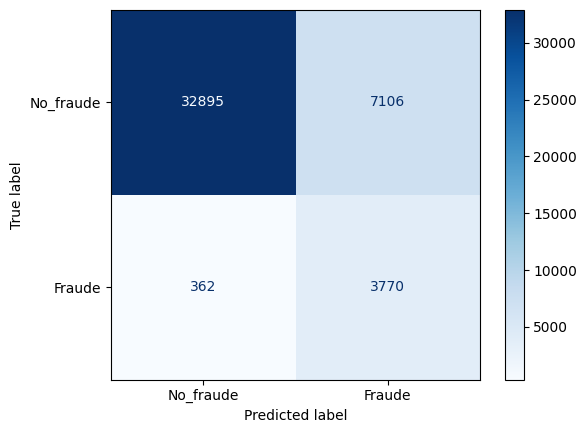

Accuracy en el conjunto de prueba: 0.8307842204246255
Recall en el conjunto de prueba: 0.9123910939012585


In [15]:
# traemos nuestros datos de prueba y vemos el rendimiento

data_test = pd.read_csv('test.csv')

x_test = data_test.drop(columns=['isFraud'])
y_test = data_test['isFraud']

y_test_pred = pipeline_final_xgb.predict(x_test)

# evaluamos los resultados
# Obtenemos nuestras metricas
test_acc = accuracy_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)

# tambien obtenemos nuestra matriz de confussion, pero de una forma más llamtiva
matriz_confusion_test = confusion_matrix(y_test, y_test_pred)

# Visualización de la matriz de confusión
cm_display = ConfusionMatrixDisplay(confusion_matrix=matriz_confusion_test,
                                    display_labels=['No_fraude', 'Fraude']) # Reemplaza con tus etiquetas
cm_display.plot(cmap=plt.cm.Blues)
plt.show()


print(f"Accuracy en el conjunto de prueba: {test_acc}")
print(f"Recall en el conjunto de prueba: {test_recall}")


Este pipeline es aún mejor que el conseguido con el método Random Forest Classifier, desde luego, hay mucho rango de mejora aún, sin embargo, clasificar el 17.5% de operaciones legales como fraudulentas con el fin de detectar más del 90% de fraudes correctamente es algo que se puede manejar en un escenario real. Ese 17% de operaciones e pueden ir aprobando con metodos complementarios, como mensajes, llamadas, notificaciones, etc.

In [16]:
os.chdir('/content/drive/MyDrive/models_fraud')

In [17]:
# Salvamos nuestro pipeline

from joblib import dump

# Guardamos el pipeline
dump(pipeline_final_xgb, 'pipeline_final_xgb.joblib')

['pipeline_final_xgb.joblib']

In [18]:
# si quisieramos caragarlo en otro notebook

#from joblib import load

# Cargamos el pipeline
#pipeline_final_xgb = load('pipeline_final_xgb.joblib')